# Predicting Seoul Bike Rentals

In this project, we will try to predict the total number of bikes people rented in a given hour. We'll implement several machine learning models and evaluate their performance. The data we will be using comes from the 
[UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand). It contains hourly information for one year, from December 1, 2017 to November 30, 2018. There was no information regarding who gathered the data, or how they collected it.  

This is a special project for me because I spent six years living in South Korea - five of them right in the heart of Seoul. I know firsthand how common bicycling is in the city, and have done it a handful of times myself. When I lived in South Korea, most of my Korean friends [didn't own a car](https://www.statista.com/statistics/915006/south-korea-access-to-cars/#:~:text=Premium%20statistics-,South%20Korea%20%2D%20share%20of%20people%20who%20have%20access,a%20car%20in%202017%2D2018&text=This%20statistic%20shows%20the%20results,stated%20they%20owned%20a%20car.). Compare that to a place like the U.S., where almost everyone has access to a car. In fact in 2021, South Korea had a reported [24.7 million](https://en.wikipedia.org/wiki/List_of_countries_by_vehicles_per_capita#cite_note-14) vehicles, while the United States had an estimated [289.5 million](https://hedgescompany.com/automotive-market-research-statistics/auto-mailing-lists-and-marketing/)! 

Everyone in South Korea can reliably depend on subways, buses, and taxis. The public transportation system there (especially in Seoul) is one of the [best in the world](http://www.koreaherald.com/view.php?ud=20150325000952). It would be no surprise to learn that more Koreans are [turning to bikes](http://www.koreaherald.com/view.php?ud=20111118000522#:~:text=More%20than%2011%20million%20people,is%20better%20for%20the%20environment.) to get around from place to place. While there was no documentation on what company our data came from, I'm willing to bet it was [Seoul Public Bike](https://english.seoul.go.kr/service/movement/seoul-public-bike/1-seoul-public-bike/), also known as 따릉이, or 

## Project Goals
* Exploratory Data Analysis on our data set:
    * Create some nice visualizations to better understand what we're working with
* Data Cleaning & Feature Engineering:
    * Understand the columns of our data set, and reduce or remove any redundant/unnecessary information
* Model Training and Evaluation:
    * Test several models (Linear Regression, Decision Tree, Random Forest)
* Visualization
    * Create clear, aesthetically pleasing visualizations
    
# Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import pylab

from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Initial Data Exploration

In order to read in our dataset, we usually use the [pandas.read_csv() method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html), which by default uses the UTF-8 encoding. However, because this dataset deals with South Korea, I presumed there would be some Korean characters in the columns, which would prevent us from reading it in normally. After reading up about the different [encodings](https://docs.python.org/3/library/codecs.html#standard-encodings), and several trial-and-error attempts, I was able to read in our data using the `cp949` encoding.

In [2]:
#read in data
seoul_rentals = pd.read_csv('SeoulBikeData.csv', encoding='cp949')
seoul_rentals.head()

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Renaming Columns

There is some inconsistency with the naming of the columns, specifically with regards to the spacing and capitalization. Let's create a mapping dictionary with renamed column names that are consistent and remove and Korean words.

In [3]:
names = {'Temperature(캜)':'Temp',
         'Humidity(%)':'Humidity',
         'Wind speed (m/s)':'Wind Speed',
         'Visibility (10m)':'Visibility',
         'Dew point temperature(캜)':'Dew Point Temp',
         'Solar Radiation (MJ/m2)':'Solar Radiation',
         'Rainfall(mm)':'Rainfall',
         'Snowfall (cm)':'Snowfall',
         'Seasons':'Season',
         'Functioning Day':'Open For Business'}

seoul_rentals.rename(columns=names, inplace=True)

## Columns & Data Types

Our dataset did not come with any kind of data dictionary, but thankfully it's mostly straightforward.

In [4]:
#get datatypes and null counts
seoul_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               8760 non-null   object 
 1   Rented Bike Count  8760 non-null   int64  
 2   Hour               8760 non-null   int64  
 3   Temp               8760 non-null   float64
 4   Humidity           8760 non-null   int64  
 5   Wind Speed         8760 non-null   float64
 6   Visibility         8760 non-null   int64  
 7   Dew Point Temp     8760 non-null   float64
 8   Solar Radiation    8760 non-null   float64
 9   Rainfall           8760 non-null   float64
 10  Snowfall           8760 non-null   float64
 11  Season             8760 non-null   object 
 12  Holiday            8760 non-null   object 
 13  Open For Business  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


We can see we have 14 different columns, which I will describe as the following:

* **Date** - The date in DD/MM/YYYY format
* **Rented Bike Count** - Number of bikes rented in that hour
* **Hour** - Hour of the day (ranges from 0-23)
* **Temp** - Temperature in Celsius
* **Humidity** - Humidity in percent
* **Wind Speed** - Wind speed (m/s)
* **Visibility** - The distance (in meters) you can clearly see ahead of you. 
* **Dew Point Temp** - Temperature in Celsius at which dew begins to form
* **Solar Radiation** - Electromagnetic radiation (solar energy) from the sun
* **Rainfall** - Amount of rainfall (mm) at the given hour
* **Snowfall** - Amount of snowfall (cm) at the given hour
* **Season** - Current season
* **Holiday** - Whether or not that day was a national holiday
* **Open For Business** - Whether or not the rental offices are open  

We can also see that in addition to not having any null values, we have a mix of data types in our data set. Most of them are numerical, but there are a handful that are strings. Namely `Date`, `Seasons`, `Holiday`, and `Open For Business`. We should probably convert the `Date` column into datetime data type, to make any further processing simpler. The `Seasons` column can be considered categorical, which can pose problems for a linear regression model. We might be better off implementing [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) because with categorical data, we can't rightfully say that one season is greater than or less than another - only different. And for the `Holiday` and `Open For Business` columns, there's no real need for us to keep them as strings since our models won't be able to process them.

## Basic Statistics

In [5]:
seoul_rentals.describe()

,Rented Bike Count,Hour,Temp,Humidity,Wind Speed,Visibility,Dew Point Temp,Solar Radiation,Rainfall,Snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


From the above we can make some basic observations:

* **Rented Bike Count**: ranges from 0-3556
* **Temperature**: ranges from -17.8-39.4 °C
* **Humidity**: ranges from 0-98 %
* **Rainfall**: ranges from 0-35 mm

## Unique Values

In [6]:
seoul_rentals.nunique()

Date                  365
Rented Bike Count    2166
Hour                   24
Temp                  546
Humidity               90
Wind Speed             65
Visibility           1789
Dew Point Temp        556
Solar Radiation       345
Rainfall               61
Snowfall               51
Season                  4
Holiday                 2
Open For Business       2
dtype: int64

From the above we can make some more observations:

* We have information for 365 days
* The `Seasons`, `Holiday`, and `Functioning Day` columns can (and will be) be reconfigured to something more useful since they only have 4/2/2 unique values respectively.

## Rental Count Distribution

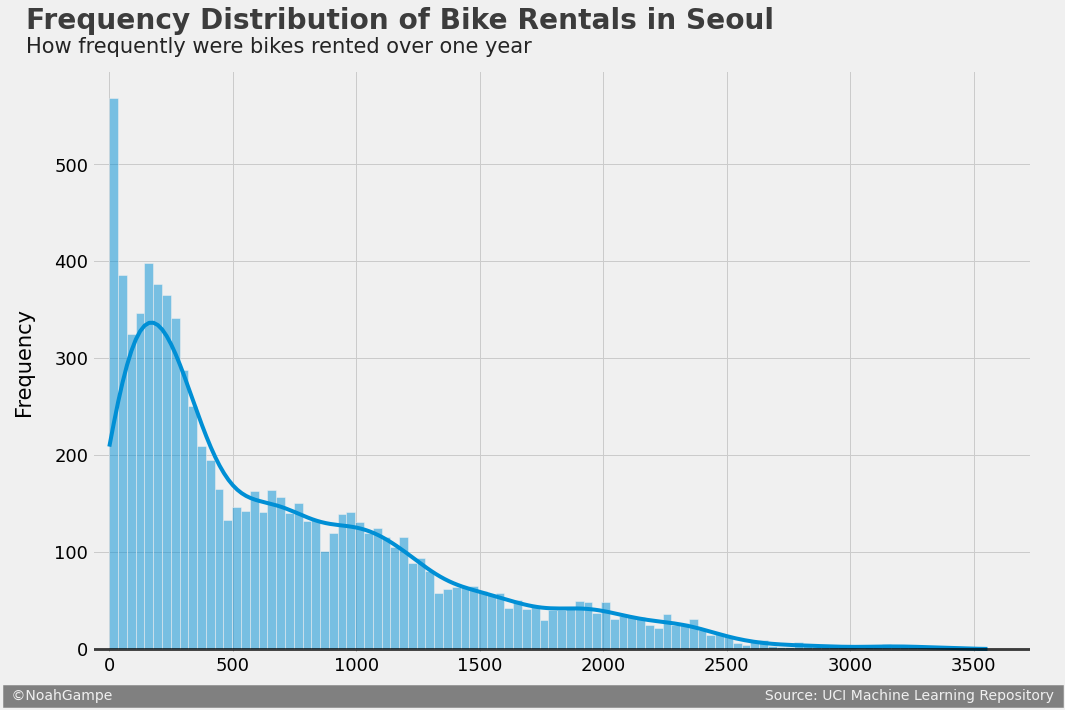

In [7]:
def plot_dist(df, col, title, sub):
    fig = plt.figure(figsize=(15,10))
    ax = sns.histplot(data=df, x=col, bins=100, kde=True)
        
    #lines, labels, and limits
    ax.axhline(y=-0.1, color='black', linewidth=3, alpha=.7)
    ax.set_ylabel('Frequency', fontsize=21, labelpad=20)
    ax.xaxis.label.set_visible(False)
    ax.set_xlim(df[col].max()*-0.02, None)
    ax.set_ylim(-4, None)
    ax.tick_params(labelsize=18)

    #title & subtitle
    ax.text(-0.07,1.07, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax.transAxes)
    ax.text(-0.07,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.09, y=-0.08,
            s=' ©NoahGampe' + ' '*145 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()

title = 'Frequency Distribution of Bike Rentals in Seoul'
sub = 'How frequently were bikes rented over one year'
plot_dist(seoul_rentals, 'Rented Bike Count', title, sub)

We can see from the first bar of our histogram that there were zero (or near zero) bike rentals more often than any other amount. This makes sense because our data was collected hourly, which means there is data for late-nights and very early-mornings, which is not a common time for people to be awake, let alone renting and riding bikes.

# Transform Categorical Data

We can split up some of our categorical data so that our models will have a better time handling it. We can use the [pandas.get_dummies() method](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to convert our categorical data into numerical data. Then we'll use the [pandas.drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html?highlight=drop#pandas.DataFrame.drop) and [pandas.join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join) methods to remove the old column, and add the new ones. We'll transform the following columns:

* `Season`
* `Holiday`
* `Open For Business`

Afterwards, we can convert the `Date` column to a proper datetime format.

## Season

In [8]:
#creates dummy columns, drops original column, and joins dummies
def cat_to_num(df, col):
    one_hot = pd.get_dummies(df[col])
    df.drop(col, axis=1, inplace=True)
    df = df.join(one_hot)
    return df

seoul_rentals = cat_to_num(seoul_rentals, 'Season')
seoul_rentals.head()

,Date,Rented Bike Count,Hour,Temp,Humidity,Wind Speed,Visibility,Dew Point Temp,Solar Radiation,Rainfall,Snowfall,Holiday,Open For Business,Autumn,Spring,Summer,Winter
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1


## Holiday

With our `Holiday` column, we actualy don't *need* two columns to describe this information. We will create the dummy columns, which results in giving us two separate columns - one for `Holiday` and another for `No Holiday`. However, logically it follows that if there is a `0` for `Holiday`, there would be a `1` for `No Holiday` and vice-versa. Due to this, we can remove one of our newly created dummy columns. In this case, we'll remove the `No Holiday` column.

In [9]:
seoul_rentals = cat_to_num(seoul_rentals, 'Holiday')
seoul_rentals.drop('No Holiday', axis=1, inplace=True)
seoul_rentals.head()

,Date,Rented Bike Count,Hour,Temp,Humidity,Wind Speed,Visibility,Dew Point Temp,Solar Radiation,Rainfall,Snowfall,Open For Business,Autumn,Spring,Summer,Winter,Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes,0,0,0,1,0
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes,0,0,0,1,0
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes,0,0,0,1,0
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes,0,0,0,1,0
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes,0,0,0,1,0


## Open For Business

Similar to our `Holiday` column, we can follow the same process of making our dummy columns, then removing one of them.

In [10]:
seoul_rentals = cat_to_num(seoul_rentals, 'Open For Business')
seoul_rentals.drop('No', axis=1, inplace=True)
seoul_rentals.rename(columns={'Yes':'Open For Business'}, inplace=True)
seoul_rentals.head()

,Date,Rented Bike Count,Hour,Temp,Humidity,Wind Speed,Visibility,Dew Point Temp,Solar Radiation,Rainfall,Snowfall,Autumn,Spring,Summer,Winter,Holiday,Open For Business
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,1,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,1,0,1


## Date

We can convert the `Date` column, which is currently stored as strings, into a datetime object using the [strptime() method](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime).

In [11]:
seoul_rentals['Date'] = seoul_rentals['Date'].apply(lambda x:
                                                    datetime.strptime(x,'%d/%m/%Y'))

# Feature Correlation

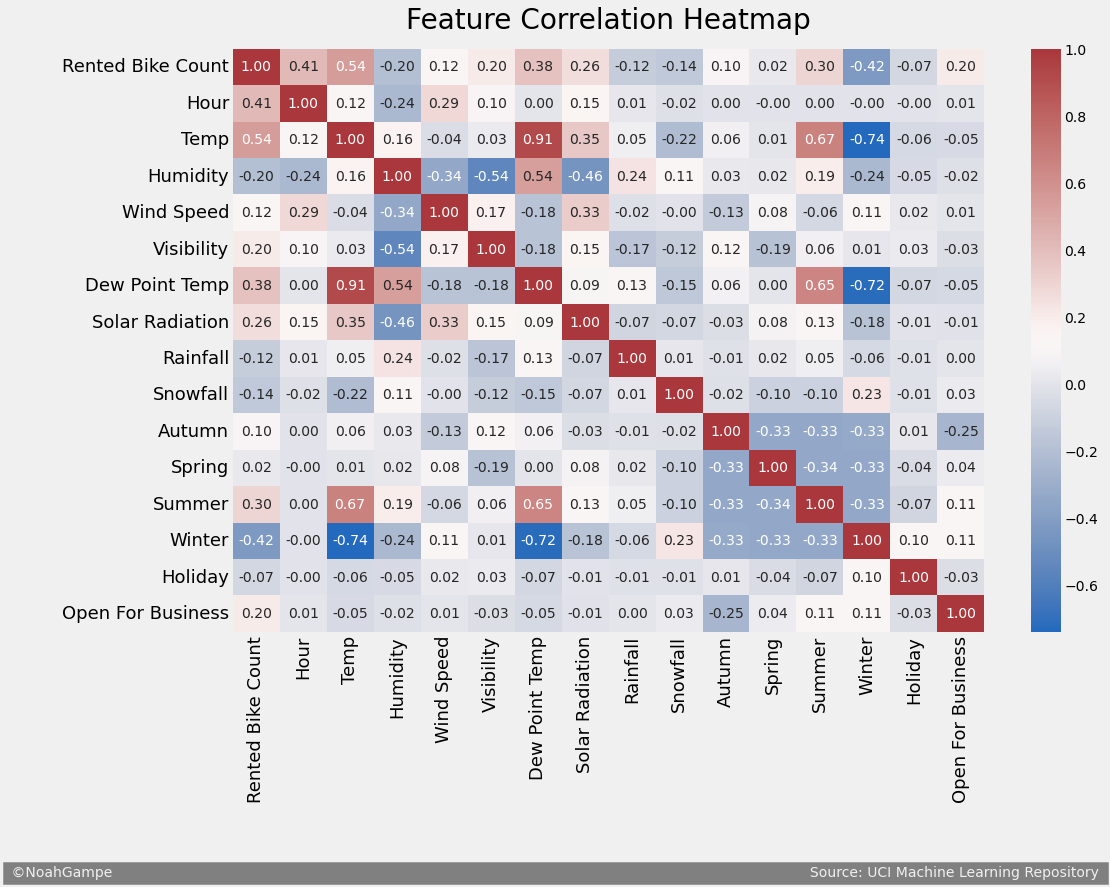

In [12]:
def plot_heatmap(df):
    fig = plt.figure(figsize=(15,10))
    ax = sns.heatmap(df.corr(), fmt='.2f', annot=True, cmap='vlag')
    ax.set_title('Feature Correlation Heatmap', fontsize=28, pad=20)
    ax.tick_params(axis = 'x', labelsize=18, rotation = 90)
    ax.tick_params(axis = 'y', labelsize=18)
    
    #signature bar
    ax.text(x=-0.3, y=-0.42,
            s=' ©NoahGampe' + ' '*155 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()
    
plot_heatmap(seoul_rentals)

We can see from our heatmap (coincidentally using the same colors as the [Korean flag](https://www.google.com/url?sa=i&url=https%3A%2F%2Fasiasociety.org%2Feducation%2Ftaegeuk&psig=AOvVaw1iS2HrrMXRei3nC8jlcjDV&ust=1648232732264000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJCCy8av3_YCFQAAAAAdAAAAABAD)) that there are a couple key correlations with the `Rented Bike Count`:

* **Hour** - the hour of the day would definitely impact when people rent bikes
* **Temp** - Korea gets all four [distinctive seasons](https://www.selectiveasia.com/south-korea-holidays/weather#:~:text=There%20are%20only%20minimal%20regional,winter%20(December%20to%20March).), so the temperature can have a big impact on whether or not someone decides to rent a bike
* **Humidity** - Korea can get [very humid](https://weather-and-climate.com/average-monthly-Humidity-perc,Seoul,South-Korea) during the summers, and humidity has a big impact on whether or not people even [go outside](https://travel-stained.com/how-to-survive-seoul-summer/)
* **Dew Point Temp** - this can have an effect of how people feel, as well as how slick the roads can be
* **Summer** - Despite the heat and humidity, people love being outside in the summer, it would make sense that more bikes are rented during the warmer months
* **Winter** - Winter on the other hand, is [incredibly cold](https://www.climatestotravel.com/climate/south-korea/seoul#:~:text=In%20winter%2C%20the%20average%20temperature,C%20(%2D4%20%C2%B0F).), and most people don't even dare go outside, which means fewer bike rentals

# Feature Engineering - Time of Day Label

While our dataset is nice, it's not perfect. A machine learning model may treat each hour differently, without having the understanding that certain hours of the day are related. We can create a new column with labels for the [time of day](https://urduesl.com/parts-of-the-day/) ('Morning', 'Afternoon', 'Night', etc.)  

Additionally, we can add a column to determine what day of the week it is. We can accomplish this by using the [datetime.weekday() method](https://docs.python.org/3/library/datetime.html#datetime.datetime.weekday) to automatically calculate and assign a number for each weekday (Monday is assigned a `0`, and Sunday is assigned a `6`).

In [13]:
#function to assign label given an hour
def assign_label(hour):
    if 0 <= hour < 2:
        return 0 #late night
    elif 2 <= hour < 6:
        return 1 #early morning
    elif 6 <= hour < 12:
        return 2 #morning
    elif 12 <= hour < 17:
        return 3 #afternoon
    elif 17 <= hour < 21:
        return 4 #evening
    elif 21 <= hour < 24:
        return 5 #night
    else:
        return -1 #error

#assigns time label based on hour of day
seoul_rentals['Time Label'] = seoul_rentals['Hour'].apply(assign_label)

#assigns number to designate day of the week (monday-0, sunday-6)
seoul_rentals['Weekday'] = seoul_rentals['Date'].apply(lambda x:
                                                      x.weekday())

In [14]:
seoul_rentals[['Time Label', 'Weekday']]

,Time Label,Weekday
0,0,4
1,0,4
2,1,4
3,1,4
4,1,4
...,...,...
8755,4,4
8756,4,4
8757,5,4
8758,5,4


We can see that we now have two new columns for both of our desired pieces of data. Now we can create a better visualization for the number of bike rentals per hour, per day.

# Further Analysis

## Distribution of Bike Rentals Per Hour

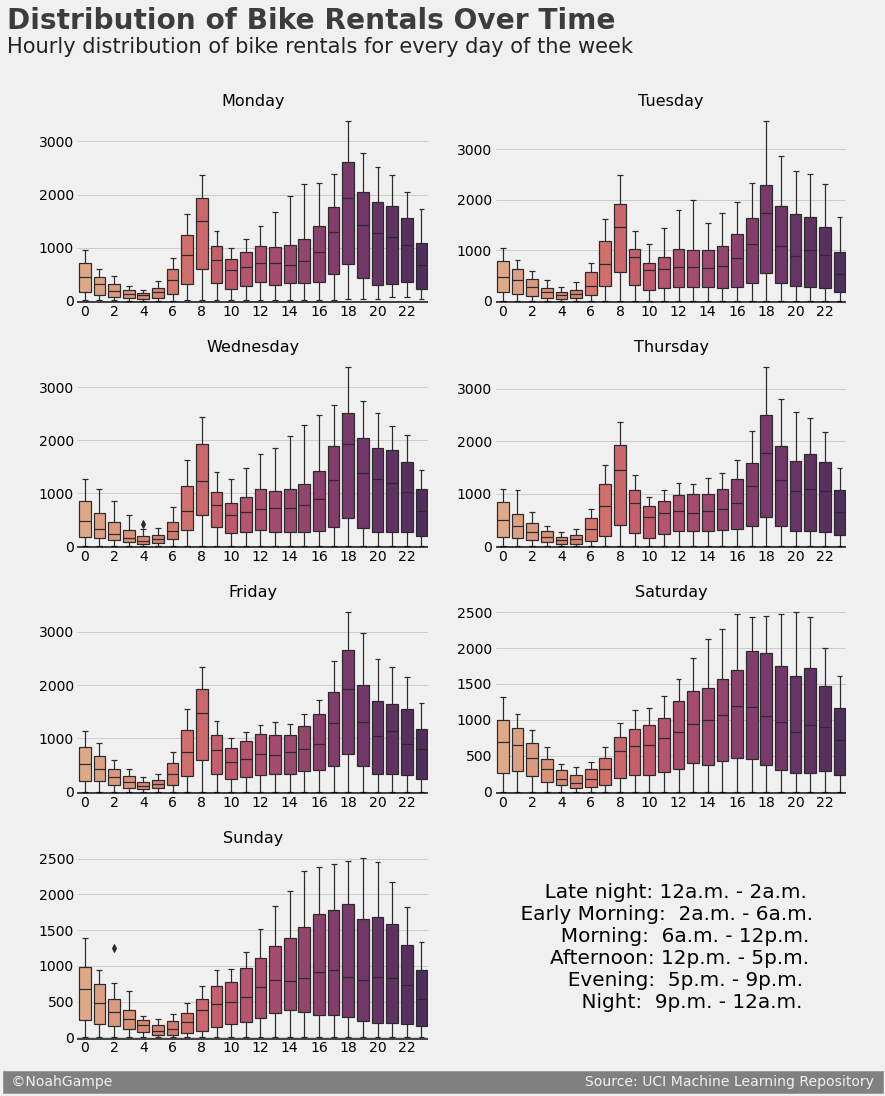

In [15]:
def plot_dist_over_time(df, target, title, sub, time='Hour'):
    fig = plt.figure(figsize=(12,14))
    
    #dictionary to hold the days of the week
    days = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    if time != 'Hour':
        time_labels = ['Late\nNight', 'Early\nMorning', 'Morning',
                       'Afternoon', 'Evening', 'Night']
        
    #for each day of the week, create a boxplot
    for i in range(7):
        #subplot details
        ax = fig.tight_layout(pad=2, w_pad=2, h_pad=1.5)
        ax = fig.add_subplot(4,2,i+1)
        
        #plot
        ax = sns.boxplot(x=df[df['Weekday'] == i][time], y=df[target], linewidth=1.2, palette='flare')
        
        #labels, lines, and limits
        ax.axhline(y=-20, color='black', linewidth=2, alpha=.7)        
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # ax.tick_params(axis='both', labelsize=18)
        ax.tick_params(axis='x', pad=-5)
        if time != 'Hour':
            ax.set_xticks(np.arange(6), labels=time_labels, fontsize=11)
        else:
            ax.set_xticks(np.arange(0, 24, 2))
        
        #subplot title (day of the week)
        ax.set_title(days[i], fontsize=16)

    #figure title & subtitle 
    ax.text(-0.2, 5.15, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax.transAxes)
    ax.text(-0.2, 5.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)

    #text describing times of day
    text = """
       Late night: 12a.m. - 2a.m.
    Early Morning:  2a.m. - 6a.m.
          Morning:  6a.m. - 12p.m.
        Afternoon: 12p.m. - 5p.m.
          Evening:  5p.m. - 9p.m.
            Night:  9p.m. - 12a.m.
    """

    #for times of day info
    ax8 = fig.add_subplot(4,2,8)
    ax8.text(0.45, 0.5, text, transform=ax8.transAxes, va='center', ha='center', fontsize=20)
    ax8.xaxis.label.set_visible(False)
    ax8.yaxis.label.set_visible(False)
    ax8.grid(False)
    ax8.axis('off')

    #signature bar
    ax.text(x=-0.2, y=-0.2,
            s=' ©NoahGampe' + ' '*105 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()
    
title = 'Distribution of Bike Rentals Over Time'
sub = 'Hourly distribution of bike rentals for every day of the week'
plot_dist_over_time(seoul_rentals, 'Rented Bike Count', title, sub)

We can see from our above plot that during weekdays (Monday-Friday) there are a couple of clear spikes in bike rentals:  

* Between 7-8a.m. - this would be the morning rush hour, where everyone tries to get to work
* Between 5-7p.m. - this would be the evening rush hour, where everyone tries to get home from work

During the weekends however, we notice the lack of a spike and instead see a more gradual increase in rentals as the day goes on.

## Distribution of Bike Rentals Over Times of Day

We can reproduce the same visualization, but instead of using our `Hour` column, we can substitute in our newly-made `Time Label` column instead. This can produce a graph that may be a bit more human-readable.

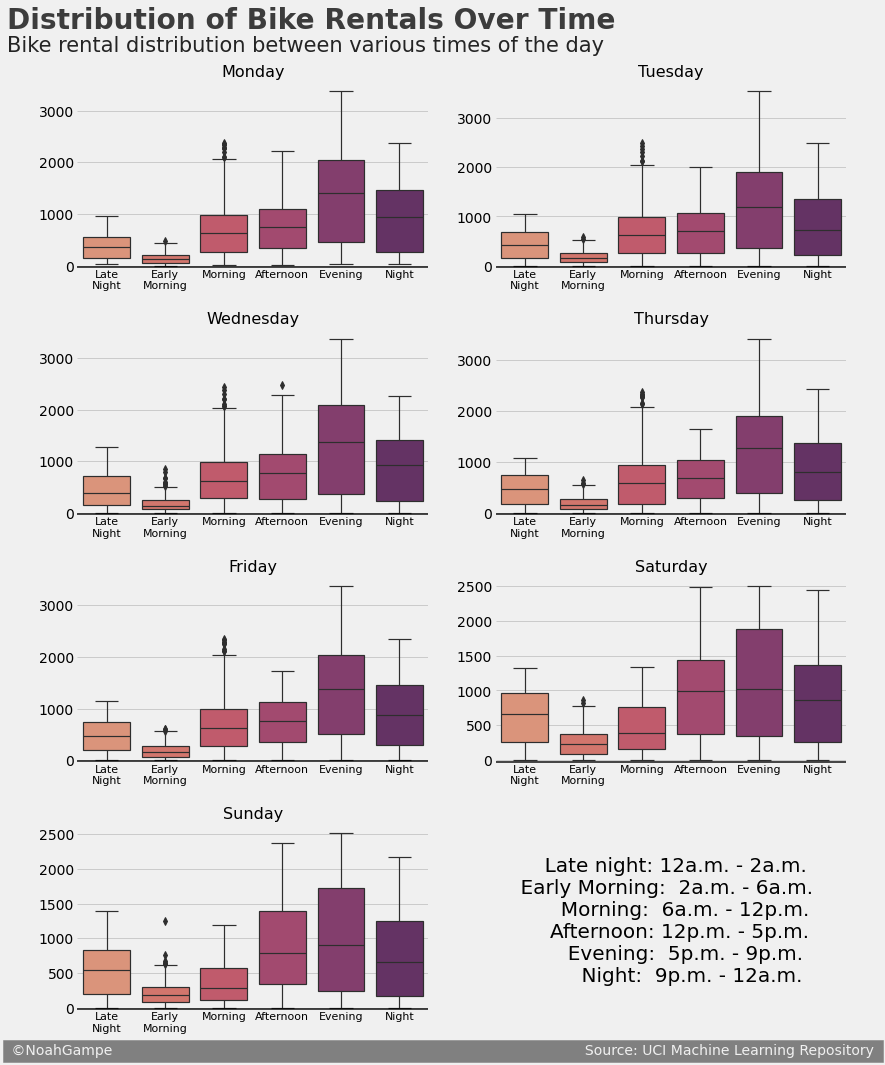

In [16]:
title = 'Distribution of Bike Rentals Over Time'
sub = 'Bike rental distribution between various times of the day'
plot_dist_over_time(seoul_rentals, 'Rented Bike Count', title, sub, 'Time Label')

The graphs don't show us anything "new", but they do make the visualization easier to interpret and understand. We can clearly see that the mornings and evenings see the big spikes in rentals, because that is when people are shuffling between home and office. On the weekends, we can see an overall increase in the number of rentals throughout the course of the day. This is most likely because it's the weekend and people want to get outside and be active.

## Weekdays vs. Weekends - By Hour

How different are the distributions between weekdays and weekends? We can create a function to help us calculate this.

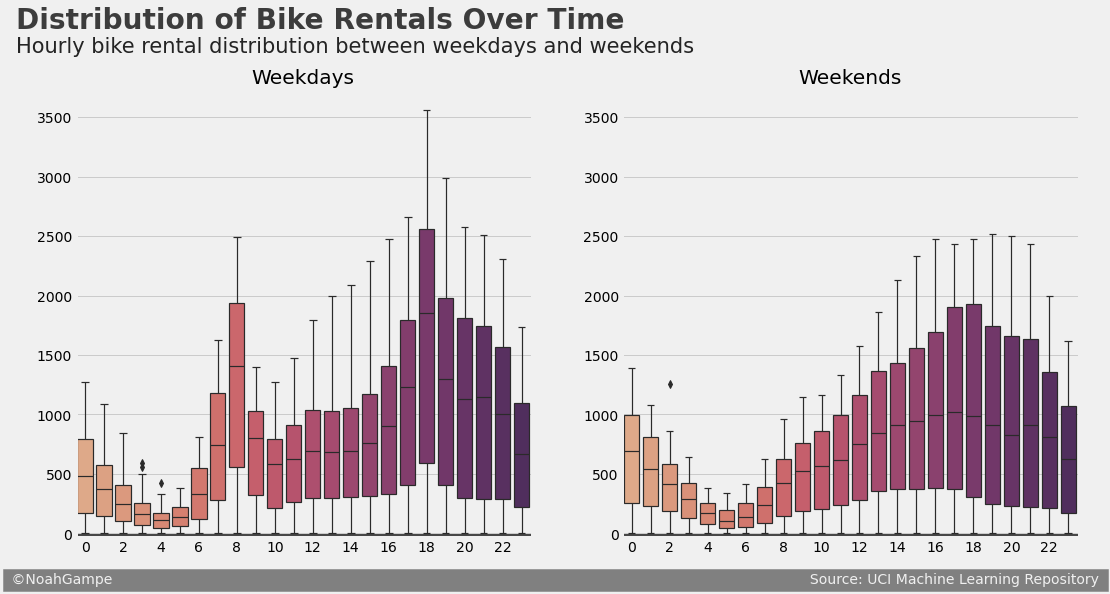

In [17]:
def plot_weekday_vs_weekend(df, target, title, sub, time='Hour'):
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2, sharey=ax1)
    axes = [ax1, ax2]
    
    if time != 'Hour':
        time_labels = ['Late\nNight', 'Early\nMorning', 'Morning',
                       'Afternoon', 'Evening', 'Night']
    
    for cur_ax in axes:
        if cur_ax == ax1: #weekdays
            cur_ax = sns.boxplot(x=df[(df['Weekday'] != 5) & (df['Weekday'] != 6)][time], y=df[target],
                            linewidth=1.2, palette='flare', ax=cur_ax)
            cur_ax.set_title('Weekdays')
        else: #weekends
            cur_ax = sns.boxplot(x=df[(df['Weekday'] == 5) | (df['Weekday'] == 6)][time], y=df[target],
                            linewidth=1.2, palette='flare', ax=cur_ax)
            cur_ax.set_title('Weekends')
        
        #labels, lines, and limits
        cur_ax.axhline(y=-10, color='black', linewidth=2, alpha=.7)
        cur_ax.spines['right'].set_visible(False)
        cur_ax.spines['top'].set_visible(False)
        cur_ax.spines['bottom'].set_visible(False)
        cur_ax.xaxis.label.set_visible(False)
        cur_ax.yaxis.label.set_visible(False)
        cur_ax.tick_params(axis='x', pad=-15)
        if time != 'Hour':
            cur_ax.set_xticks(np.arange(6), labels=time_labels, fontsize=11)
        else:
            cur_ax.set_xticks(np.arange(0, 24, 2))
        
    #figure title & subtitle 
    ax1.text(-0.13, 1.13, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax1.transAxes)
    ax1.text(-0.13, 1.08, s=sub, fontsize=21, alpha=.85, transform=ax1.transAxes)
    
    #signature bar
    ax1.text(x=-0.15, y=-0.06,
            s=' ©NoahGampe' + ' '*155 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax1.transAxes)
    
    plt.show()

title = 'Distribution of Bike Rentals Over Time'
sub = 'Hourly bike rental distribution between weekdays and weekends'
plot_weekday_vs_weekend(seoul_rentals, 'Rented Bike Count', title, sub)

Again, we can clearly see the big spike in bike rentals fduring weekdays, but that obvious spike is absent on the weekends. The weekend shows a smoother, gradual increase in the amount of bikes rented throughout the day.

## Weekdays vs. Weekends - By Time of Day

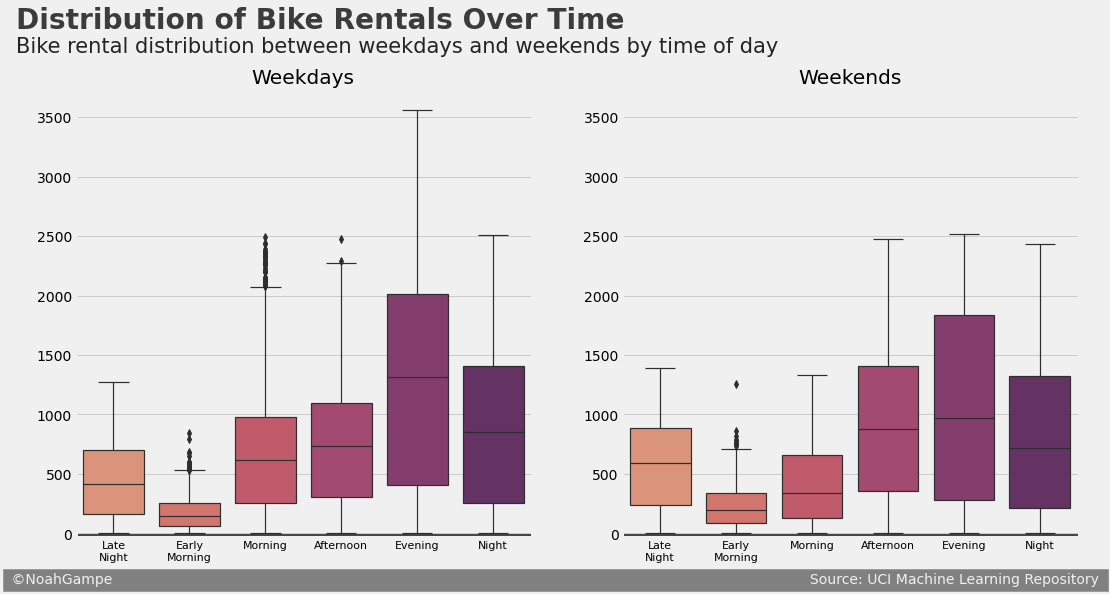

In [18]:
sub = 'Bike rental distribution between weekdays and weekends by time of day'
plot_weekday_vs_weekend(seoul_rentals, 'Rented Bike Count', title, sub, 'Time Label')

## Weather Impact

Let's see how much (if any) the weather impacted bike rentals.

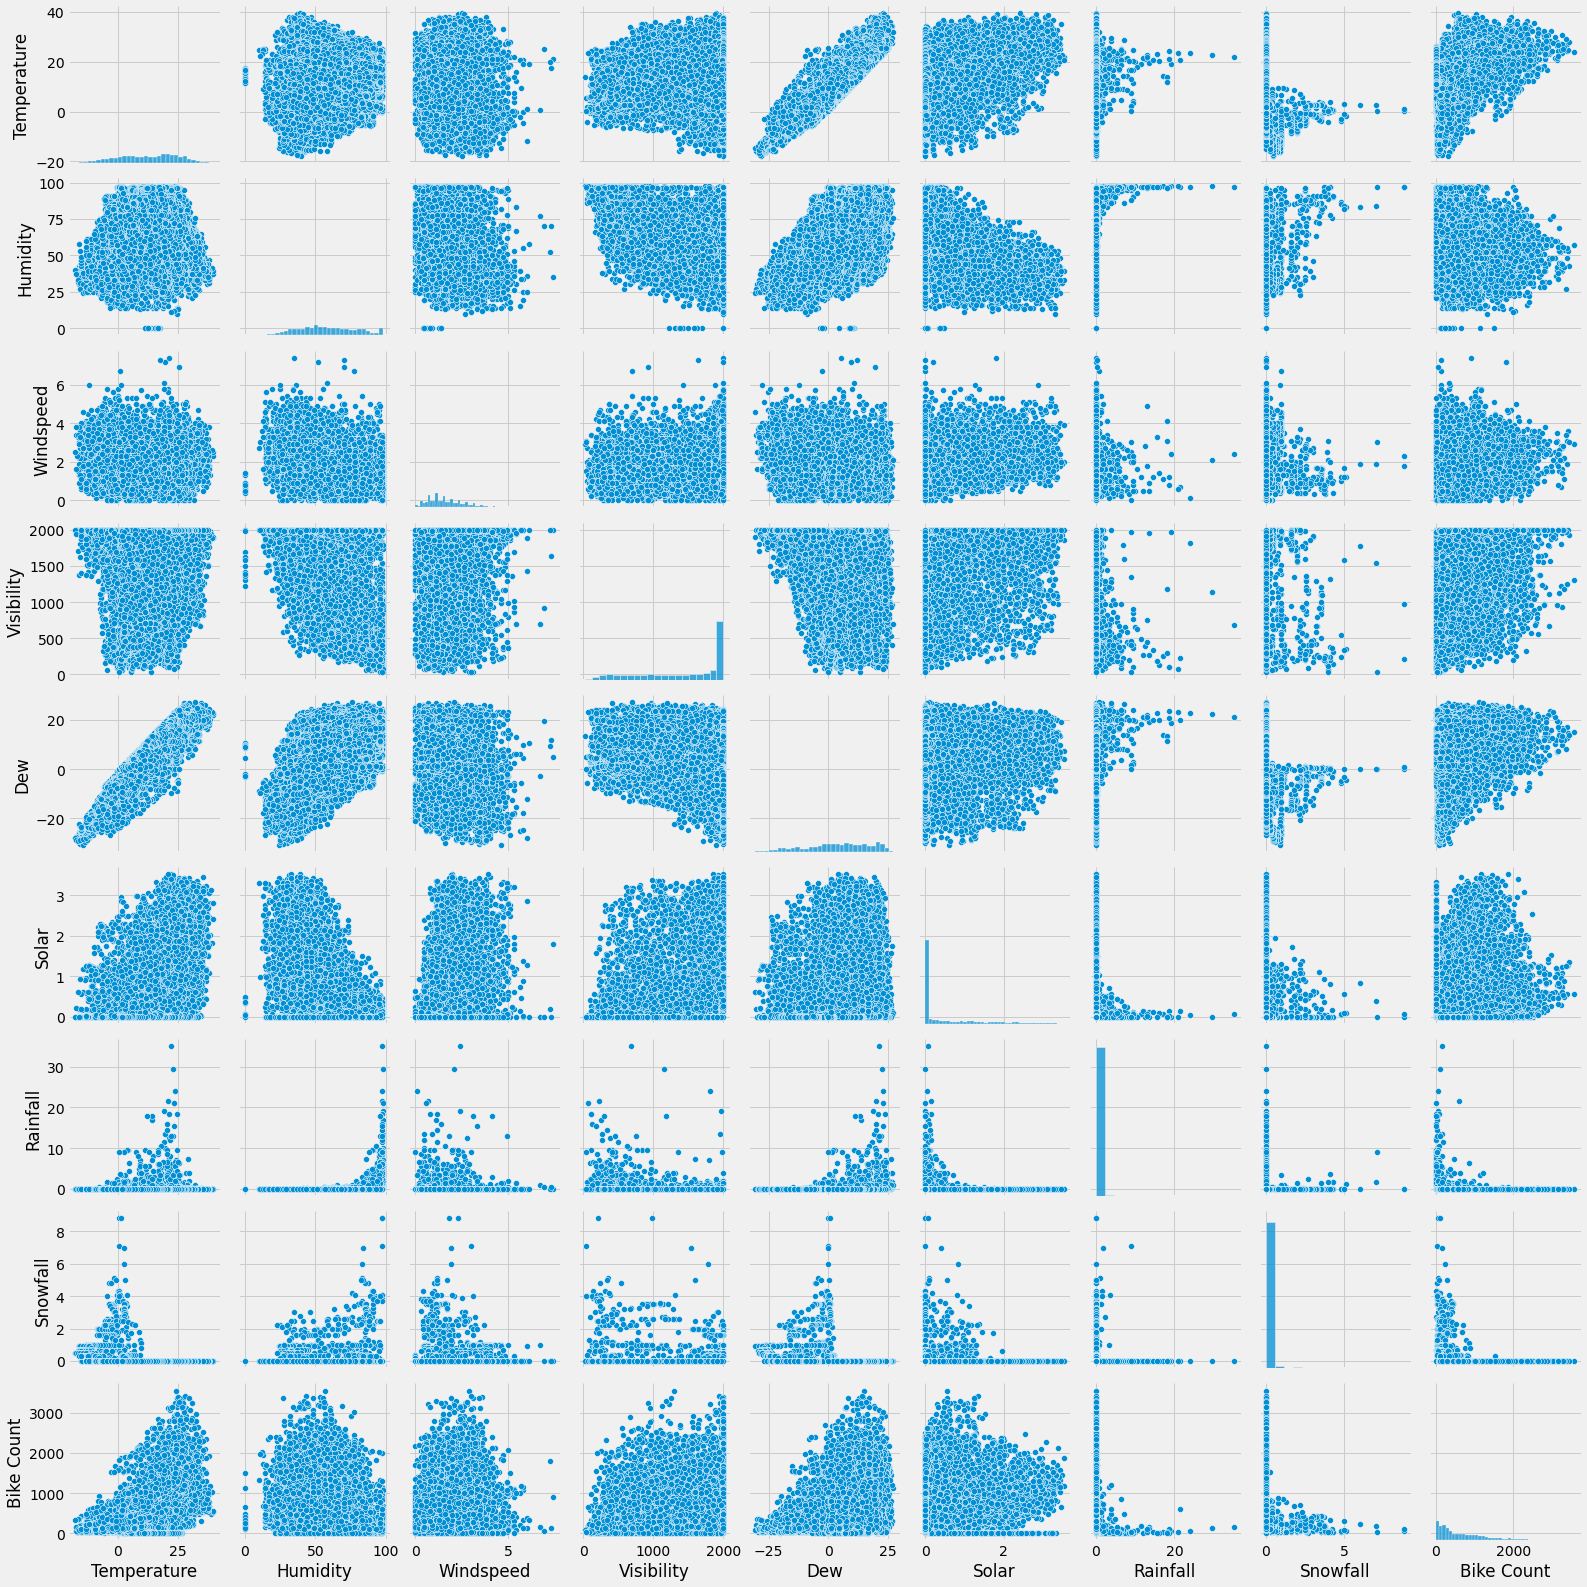

In [19]:
df_pairplot = pd.DataFrame()
df_pairplot['Temperature'] = seoul_rentals['Temp']
df_pairplot['Humidity'] =  seoul_rentals['Humidity']
df_pairplot['Windspeed'] =  seoul_rentals['Wind Speed']
df_pairplot['Visibility'] = seoul_rentals['Visibility']
df_pairplot['Dew'] = seoul_rentals['Dew Point Temp']
df_pairplot['Solar'] = seoul_rentals['Solar Radiation']
df_pairplot['Rainfall'] = seoul_rentals['Rainfall']
df_pairplot['Snowfall'] = seoul_rentals['Snowfall']
df_pairplot['Bike Count'] = seoul_rentals['Rented Bike Count']
sns.pairplot(df_pairplot)
plt.show()

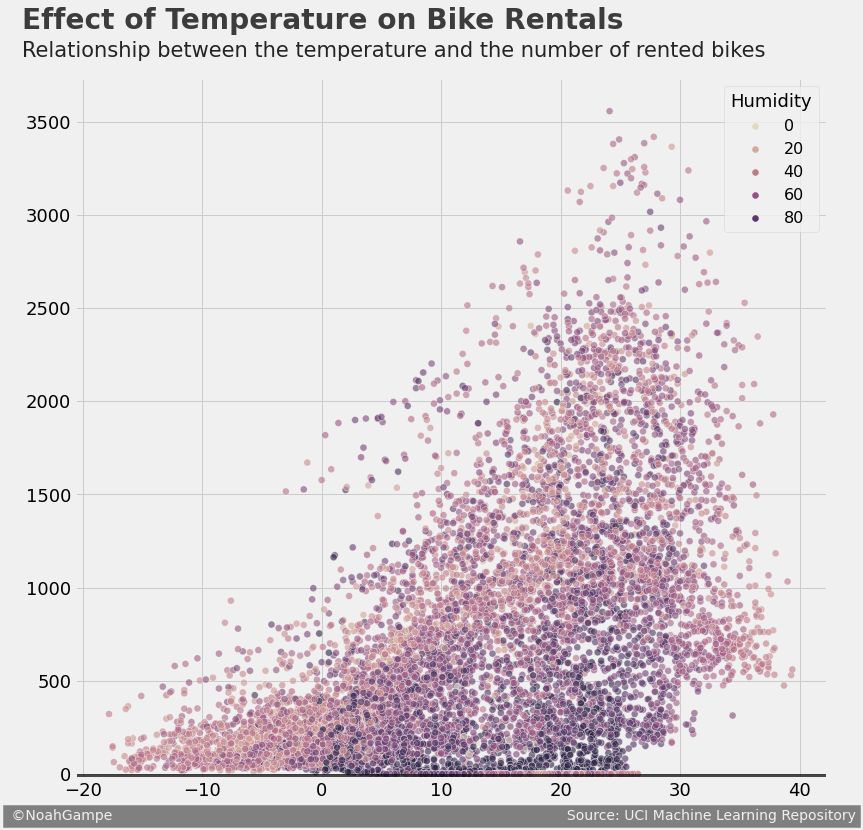

In [20]:
def plot_scatter(df, col1, col2, title, sub, col3=None):
    fig = plt.figure(figsize=(12,12))
    
    #plot
    ax = sns.scatterplot(data=df, x=df[col1], y=df[col2], hue=col3, s=50,
                         alpha=0.6, palette=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
        
    #lines, labels, and limits
    ax.axhline(y=-5, color='black', linewidth=3, alpha=.7)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(labelsize=18)
    ax.set_ylim(-20, None)

    #legend
    ax.legend(loc=0, title=col3, title_fontsize=18, fontsize=16, frameon=True)
    
    #title & subtitle
    ax.text(-0.07,1.07, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax.transAxes)
    ax.text(-0.07,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.09, y=-0.06,
            s=' ©NoahGampe' + ' '*100 + ' Source: UCI Machine Learning Repository',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()

title = 'Effect of Temperature on Bike Rentals'
sub = 'Relationship between the temperature and the number of rented bikes'
plot_scatter(seoul_rentals, 'Temp', 'Rented Bike Count', title, sub, 'Humidity')

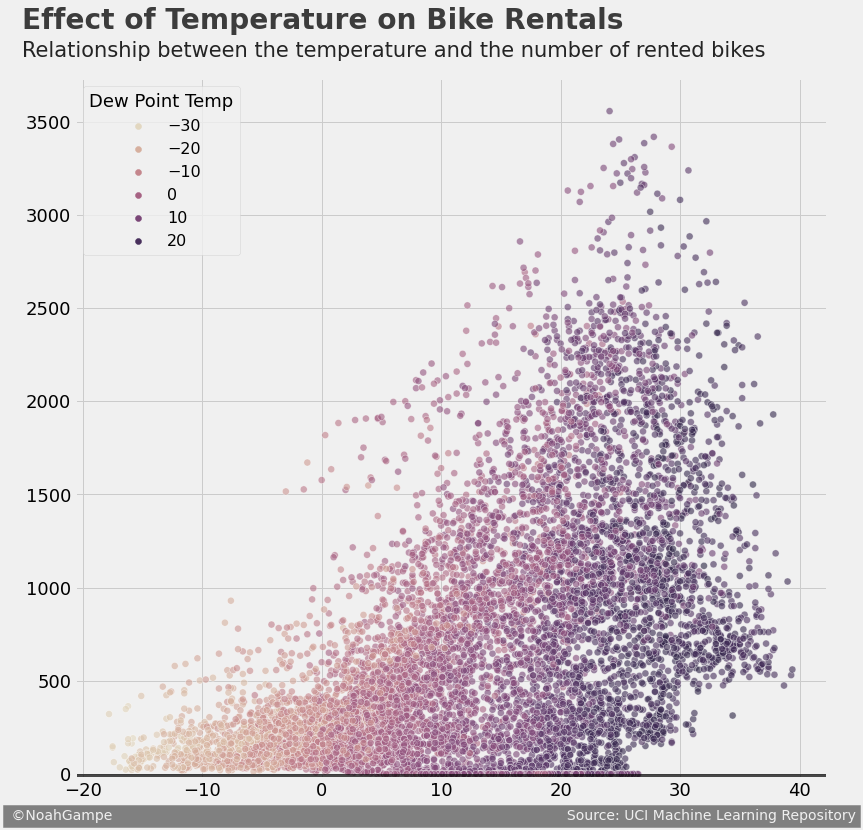

In [21]:
title = 'Effect of Temperature on Bike Rentals'
sub = 'Relationship between the temperature and the number of rented bikes'
plot_scatter(seoul_rentals, 'Temp', 'Rented Bike Count', title, sub, 'Dew Point Temp')